In [7]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from itertools import pairwise
# from labellines import labelLines
# import matplotlib.patches as mpatches

from scipy.integrate import trapezoid,dblquad,quad
from scipy.interpolate import interp1d
import scipy as sp

In [8]:
# Chord_y=interp1d([0,5.18,24],[9,7,2])
# Offset_y=interp1d([0,5.18,24],[0,2.42,13.06])
# elevation_y=interp1d([0,24],[0,24*np.sin(6*np.pi/180)])

MAC=6.26

In [9]:
def naca_6412(x):
    """
    Calcula las coordenadas del extradós e intradós del perfil NACA 6412.
    
    Parámetros:
        x (float o array): Posición sobre la cuerda (0 a 1).

    Retorna:
        xu, yu (float o array): Coordenadas del extrados
        xl, yl (float o array): Coordenadas del intrados
    """
    m = 0.06  # Máximo coeficiente de curvatura
    p = 0.4   # Posición del máximo coeficiente de curvatura
    thickness = 0.12  # Espesor máximo

    # Asegurarse de que x este en el rango [0,1]
    x=np.clip(x,0,1)

    # Cálculo del espesor
    yt = 5 * thickness * (0.2969 * np.sqrt(x) - 0.1260 * x - 0.3516 * x**2 + 0.2843 * x**3 - 0.1015 * x**4)

    # Cálculo de la línea media
    yc = np.where(x < p, m / p**2 * (2 * p * x - x**2), m / (1 - p)**2 * ((1 - 2 * p) + 2 * p * x - x**2))

    # Cálculo de la pendiente de la línea media
    dyc_dx = np.where(x < p, 2 * m / p**2 * (p - x), 2 * m / (1 - p)**2 * (p - x))
    theta = np.arctan(dyc_dx)

    # Cálculo del extrados e intrados
    xu = x - yt * np.sin(theta)
    yu = yc + yt * np.cos(theta)
    xl = x + yt * np.sin(theta)
    yl = yc - yt * np.cos(theta)

    return xu, yu, xl, yl

AREA_NACA=quad(lambda x: naca_6412(x)[1]-naca_6412(x)[3],0,1)[0]
CG_NACA_X=quad(lambda x: (naca_6412(x)[1]-naca_6412(x)[3])*x,0,1)[0]/AREA_NACA
CG_NACA_Y=quad(lambda x: (naca_6412(x)[1]**2-naca_6412(x)[3]**2)/2,0,1)[0]/AREA_NACA
CG_NACA=np.array([CG_NACA_X,CG_NACA_Y])

In [10]:
@np.vectorize
def rotate_vector(x, y, z):
    """
    Rota un vector (x, y) por un ángulo z (en radianes).

    Parámetros:
        x (float o array): Coordenada x del vector.
        y (float o array): Coordenada y del vector.
        z (float): Ángulo de rotación en radianes.

    Retorna:
        x_rot, y_rot (float o array): Coordenadas del vector rotado.
    """
    x_rot = x * np.cos(-z) - y * np.sin(-z)
    y_rot = x * np.sin(-z) + y * np.cos(-z)
    return x_rot, y_rot

In [11]:
# X=[0,1,2,3]
# Y=[1,2,3,4]
# X,Y=rotate_vector(X,Y,1)

In [ ]:
class Ala:

    base_point_ids:int=100_000
    rate_per_costilla:int=1_000

    base_surface_costilla_ids:int=1_000
    rate_per_surface_costilla:int=10

    base_line_ids:int=0

    base_surface_larguero_ids:int = base_surface_costilla_ids * 2
    rate_per_surface_largero:int=10

    base_surface_skin_ids:int = 30_000
    rate_per_surface_skin:int=100


    n_costilla:int=1
    n_seccion:int=1

    grupo_costillas="Secciones_Ala"
    grupo_largeros="Tramos_Largueros"
    grupo_largerillos="Tramos_Largerillos"
    grupo_pieles="Secciones_Piel"

    class Costilla:
        n_points_skin=100
        def __init__(self,b,pos_largeros=[0.2,0.65],pos_largerillos=np.linspace(0.05,0.8,8)):
            self.y=b
            self.pos_largeros=pos_largeros
            self.pos_largerillos=pos_largerillos
            self.IDS_largeros=[]
            self.IDS_largerillos=[]


            prop_cycle=plt.rcParams['axes.prop_cycle']
            self.colors=prop_cycle.by_key()['color']
            self.skin_points=np.linspace(0,1,self.n_points_skin)
            self.id_range=[int(Ala.base_point_ids + Ala.rate_per_costilla * Ala.n_costilla),
                        int(Ala.base_point_ids + Ala.rate_per_costilla * Ala.n_costilla + 2 * Ala.Costilla.n_points_skin - 2)]
            
            Ala.n_seccion=Ala.base_surface_costilla_ids + Ala.rate_per_surface_costilla * Ala.n_costilla
            self.actual_pos_largueros= self.calc_actual_pos_largueros()
            self.surf_id_range=[Ala.n_seccion + num for num in range(1,len(pos_largeros)*2)]
            self.actual_pos_largerillos= self.calc_actual_pos_largerillos()
            self.ses_commands=self.ses_Geom_v2()
            self.id_costilla=Ala.n_costilla
            Ala.n_costilla+=1

        @staticmethod
        def find_nearest(a, a0):
            "Element in nd array `a` closest to the scalar value `a0`"

            POS=list(zip(*a))
            idx = np.argmin([
                (element[0]-a0[0])**2 + (element[1]-a0[1])**2 for element in POS
                ])
            return int(idx),a[0][int(idx)],a[1][int(idx)]

        @property
        def vertex_largeros(self):
            #posicion de las costillas en fraccion de cuerda unitaria (sus vertices)
            XL,YL,XU,YU=[],[],[],[]

            for pos in self.pos_largeros:

                xu,yu,xl,yl=naca_6412(pos)
                #posiciones ajustadas a su posicion en la envergadura y cuerda real

                xl,yl=rotate_vector(xl,yl,Ala.Torsion_y(self.y))
                xu,yu=rotate_vector(xu,yu,Ala.Torsion_y(self.y))

                xl = xl * Ala.Chord_y(self.y) + Ala.Offset_y(self.y)
                xu = xu * Ala.Chord_y(self.y) + Ala.Offset_y(self.y)
                yl = yl * Ala.Chord_y(self.y) + Ala.elevation_y(self.y)
                yu = yu * Ala.Chord_y(self.y) + Ala.elevation_y(self.y)
                
                XL.append(xl)
                YL.append(yl)
                XU.append(xu)
                YU.append(yu)

            return XU + XL[::-1],YU + YL[::-1]
        
        @property
        def vertex_largerillos(self):
            #posicion de las costillas en fraccion de cuerda unitaria (sus vertices)
            XL,YL,XU,YU=[],[],[],[]
            for pos in self.pos_largerillos:

                xu,yu,xl,yl=naca_6412(pos)
                #posiciones ajustadas a su posicion en la envergadura y cuerda real

                xl,yl=rotate_vector(xl,yl,Ala.Torsion_y(self.y))
                xu,yu=rotate_vector(xu,yu,Ala.Torsion_y(self.y))

                xl = xl * Ala.Chord_y(self.y) + Ala.Offset_y(self.y)
                xu = xu * Ala.Chord_y(self.y) + Ala.Offset_y(self.y)
                yl = yl * Ala.Chord_y(self.y) + Ala.elevation_y(self.y)
                yu = yu * Ala.Chord_y(self.y) + Ala.elevation_y(self.y)
                
                XL.append(xl)
                YL.append(yl)
                XU.append(xu)
                YU.append(yu)

            return XU + XL[::-1],YU + YL[::-1]

        @property
        def perfil(self):
            XL,YL,XU,YU=[],[],[],[]
            for x_i in self.skin_points:

                xu,yu,xl,yl=naca_6412(x_i)
                #posiciones ajustadas a su posicion en la envergadura y cuerda real

                xl,yl=rotate_vector(xl,yl,Ala.Torsion_y(self.y))
                xu,yu=rotate_vector(xu,yu,Ala.Torsion_y(self.y))

                xl = xl * Ala.Chord_y(self.y) + Ala.Offset_y(self.y)
                xu = xu * Ala.Chord_y(self.y) + Ala.Offset_y(self.y)
                yl = yl * Ala.Chord_y(self.y) + Ala.elevation_y(self.y)
                yu = yu * Ala.Chord_y(self.y) + Ala.elevation_y(self.y)
                
                XL.append(xl)
                YL.append(yl)
                XU.append(xu)
                YU.append(yu)

            return XU + XL[::-1],YU + YL[::-1]
        
        @property
        def area_caja(self):
            areas=[]
            for i in range(len(self.pos_largeros)-1):
                w1=np.diff(self.pos_largeros)[i]
                h1=self.vertex_largeros[1][i]   - self.vertex_largeros[1][i + len(self.pos_largeros)//2]
                h2=self.vertex_largeros[1][i+1] - self.vertex_largeros[1][i + 1 + len(self.pos_largeros)//2]

                areas.append((h1+h2)*w1/2)

            return np.sum(areas)

        @property
        def area_perfil(self):
            return AREA_NACA * Ala.Chord_y(self.y)**2
        
        @property
        def CG_perfil(self):
            pos=CG_NACA * Ala.Chord_y(self.y)
            return rotate_vector(*pos,Ala.Torsion_y(self.y)) + np.array([Ala.Offset_y(self.y),Ala.elevation_y(self.y)])

        @property
        def CG_caja(self):
            pass
        
        @property
        def Nastran_string(self):
            F=[]
            for n_id,(pos_x,pos_y) in enumerate(zip(*self.perfil)):
                F.append(f'GRID     {n_id + self.id_range[0]:<7.0f} {0:<7.0f} {pos_x:<7.4f} {pos_y:<7.4f} {self.y:<7.4f} \n')
            
            return F 
        
        def ses_Geom_v2(self):
            sections=[f'#Curvas-Superficie de la {Ala.n_costilla}º costilla, a {self.y:.2f}m \n']
            
            F=['STRING asm_create_grid_xyz_created_ids[VIRTUAL]\n']
            for n_id,(pos_x,pos_y) in enumerate(zip(*self.perfil)):
                if n_id== len(self.perfil[0])-1:
                    break
                F.append(f'asm_const_grid_xyz("{n_id + self.id_range[0]:<7.0f}","[{pos_x:<7.4f} {pos_y:<7.4f} {self.y:<7.4f}]", "Coord 0", asm_create_grid_xyz_created_ids) \n')


            F.append('STRING asm_create_line_pwl_created_ids[VIRTUAL]\n')
            for id_largeros in range(len(self.IDS_largeros) // 2 + 1):
                Ala.n_seccion+=1
                if id_largeros == 0:
                    F.append(f'asm_const_line_pwl( "1", "Point {self.id_range[0]:.0f}:{self.IDS_largeros[0]:.0f} {self.IDS_largeros[-1]:.0f}:{self.id_range[-1]:.0f} {self.id_range[0]:.0f}", asm_create_line_pwl_created_ids )\n')
                    n_curvas=self.IDS_largeros[0] - self.id_range[0] + self.id_range[-1] - self.IDS_largeros[-1] + 2

                elif id_largeros == len(self.IDS_largeros) // 2:
                    F.append(f'asm_const_line_pwl( "1", "Point {self.IDS_largeros[id_largeros-1]:.0f}:{self.IDS_largeros[id_largeros]:.0f} {self.IDS_largeros[id_largeros-1]:.0f} ", asm_create_line_pwl_created_ids )\n')
                    n_curvas=self.IDS_largeros[id_largeros] - self.IDS_largeros[id_largeros-1] + 1
                else:
                    
                    id_largero_1=id_largeros-1
                    id_largero_2=id_largeros
                    id_largero_3=len(self.IDS_largeros)-1 - id_largero_2
                    id_largero_4=len(self.IDS_largeros)-1 - id_largero_1

                    F.append(f'asm_const_line_pwl( "1", "Point {self.IDS_largeros[id_largero_1]:.0f}:{self.IDS_largeros[id_largero_2]:.0f} {self.IDS_largeros[id_largero_3]:.0f}:{self.IDS_largeros[id_largero_4]:.0f} {self.IDS_largeros[id_largero_1]:.0f}", asm_create_line_pwl_created_ids )\n')
                    n_curvas=self.IDS_largeros[id_largero_2] - self.IDS_largeros[id_largero_1] + self.IDS_largeros[id_largero_4] - self.IDS_largeros[id_largero_3] + 2
                
                F.append('STRING sgm_surface_trimmed__created_id[VIRTUAL]\n')
                F.append(f'sgm_create_surface_trimmed_v1( "{Ala.n_seccion}", "Curve 1:{n_curvas}", "", "", TRUE, TRUE, TRUE,TRUE, sgm_surface_trimmed__created_id )\n')
                # F.append('$#Question from application SGM\n')
                # F.append('$# Do you wish to delete the original curves?\n')
                # F.append('$?YES\n')
                F.append(f'ga_group_entity_add( "{Ala.grupo_costillas}", "Surface {Ala.n_seccion}" )\n')
            return F

        def calc_actual_pos_largueros(self):
            X,Y,IDS=[],[],[]
            for n,pos_larguero in enumerate(zip(*self.vertex_largeros)):
                if pos_larguero not in list(zip(*self.perfil)):
                    id_x,x,y_x=self.find_nearest(self.perfil,pos_larguero)
                    X.append(x)
                    Y.append(y_x)
                    IDS.append(id_x)
                else:
                    X.append(pos_larguero[0])
                    Y.append(pos_larguero[1])
                    IDS.append(n)
            
            self.IDS_largeros=[id_i + self.id_range[0] for id_i in IDS]

            return X,Y
        
        def calc_actual_pos_largerillos(self):
            X,Y,IDS=[],[],[]
            for n,pos_largerillo in enumerate(zip(*self.vertex_largerillos)):
                if pos_largerillo not in list(zip(*self.perfil)):
                    id_x,x,y_x=self.find_nearest(self.perfil,pos_largerillo)
                    X.append(x)
                    Y.append(y_x)
                    IDS.append(id_x)
                else:
                    X.append(pos_largerillo[0])
                    Y.append(pos_largerillo[1])
                    IDS.append(n)
            
            self.IDS_largerillos=[id_i + self.id_range[0] for id_i in IDS]
            
            return X,Y

        def plot_base(self,ax=None,show_legend=False):
            if not ax:
                fig,ax =plt.subplots()
            ax.plot(self.perfil[0],self.perfil[1],color=self.colors[0],label='Perfil')

            for n_larg in range(1,len(self.IDS_largeros) // 2 + 1):

                xs=[self.vertex_largeros[0][n_larg-1],self.vertex_largeros[0][-n_larg]]
                ys=[self.vertex_largeros[1][n_larg-1],self.vertex_largeros[1][-n_larg]]

                ax.plot(xs,ys,color=self.colors[3],alpha=0.3,linestyle='-.',linewidth=4)



            ax.fill(self.perfil[0],self.perfil[1],color=self.colors[0],alpha=0.1)
            ax.set_xlabel('X [m]')
            ax.set_ylabel('Z [m]')
        
        def plot_3d(self,ax=None):
            
            if not ax:
                fig, ax = plt.subplots(subplot_kw={'projection': '3d'})


            verts=[]
            for x,z in zip(*self.perfil):
                verts.append([x,self.y,z])
            
            poly = Poly3DCollection([verts], alpha=0.5, facecolor=self.colors[0], edgecolor='blue')
            ax.add_collection3d(poly)

            
            # ax.plot(self.perfil[0],[self.y]*len(self.perfil[0]),self.perfil[1],color=self.colors[0])
            # ax.fill(self.perfil[0],self.perfil[1],[self.y]*len(self.perfil[0]),color=self.colors[0],alpha=0.1)

        
        def plot_node_names(self):

            self.plot_base()
            fig=plt.gcf()
            fig.set_size_inches(10,5)
            ax=plt.gca()
            ax.axis('off')

            
            ax.set_title(f'Costilla a {self.y:.2f} m de la raíz')

            ax.scatter(self.perfil[0][0],self.perfil[1][0],color=self.colors[0],marker='x')
            ax.text(self.CG_perfil[0] - 0.25 * Ala.Chord_y(self.y) ,self.CG_perfil[1] - 0.01 * Ala.Chord_y(self.y),
                    f"Puntos : {self.id_range} \n Superficies : {self.surf_id_range}",
                    color=self.colors[0],fontsize=16,rotation=-3*np.rad2deg(Ala.Torsion_y(self.y)))
            
            for i in range(len(self.pos_largeros)*2):
                ax.text(-0.04 * Ala.Chord_y(self.y) + self.vertex_largeros[0][i],0.012 * Ala.Chord_y(self.y) + self.vertex_largeros[1][i],
                        f'{self.IDS_largeros[i]:_.0f}',
                        color=self.colors[3],fontsize=12,rotation=-3*np.rad2deg(Ala.Torsion_y(self.y)))
                ax.scatter(self.vertex_largeros[0][i],self.vertex_largeros[1][i],color=self.colors[3],marker='o',s=80)
            
            for i in range(len(self.pos_largerillos)*2):
                ax.text(self.vertex_largerillos[0][i],-0.033 * Ala.Chord_y(self.y) + self.vertex_largerillos[1][i],
                        f'{self.IDS_largerillos[i]:_.0f}',
                        color=self.colors[1],fontsize=10,rotation=90)
                ax.scatter(self.vertex_largerillos[0][i],self.vertex_largerillos[1][i],color=self.colors[1],marker='x',s=80)

    def __init__(self,envergadura=35,n_costillas=18,pos_largeros=[0.2,0.65],pos_largerillos=np.linspace(0.05,0.8,8)):
        
        self.envergadura=envergadura
        self.set_position_scale_sections()
        self.n_costillas=n_costillas
        self.pos_largeros=pos_largeros
        self.pos_largerillos=pos_largerillos
        Ala.n_costilla=1
        self.check_name_basis()
        self.secciones=[Ala.Costilla(y,pos_largeros,pos_largerillos) for y in np.linspace(0,envergadura,n_costillas)]

        prop_cycle=plt.rcParams['axes.prop_cycle']
        self.colors=prop_cycle.by_key()['color']
        
    def set_position_scale_sections(self):

        Ala.Torsion_y=interp1d([0,self.envergadura],[np.deg2rad(2),-np.deg2rad(4)])
        Ala.Chord_y=interp1d([0,5.18,self.envergadura],[9,7,2])
        Ala.Offset_y=interp1d([0,5.18,self.envergadura],[0,2.42,13.06])
        Ala.elevation_y=interp1d([0,self.envergadura],[0,self.envergadura*np.sin(6*np.pi/180)])
    
    def check_name_basis(self):
        if Ala.rate_per_costilla < 2 * Ala.Costilla.n_points_skin:
            Ala.rate_per_costilla *= 10
            self.check_name_basis()
        
        if Ala.base_point_ids < Ala.rate_per_costilla * self.n_costillas:
            Ala.base_point_ids *= 10
            self.check_name_basis()

        if Ala.rate_per_surface_costilla < len(self.pos_largeros) + 1:
            Ala.rate_per_costilla *= 10
            self.check_name_basis()
        
        if Ala.base_surface_costilla_ids < Ala.rate_per_surface_costilla * self.n_costillas:
            Ala.base_point_ids *= 10
            self.check_name_basis()

        if Ala.rate_per_surface_skin < 2 * Ala.Costilla.n_points_skin:
            Ala.rate_per_surface_skin *= 10
            self.check_name_basis()
        
        if Ala.base_surface_skin_ids < Ala.rate_per_surface_skin * (self.n_costillas-1):
            Ala.base_surface_skin_ids *= 10
            self.check_name_basis()
    
    def save_BDF(self,filename=None):
        BDF_Nastran=[grid_elemento for seccion in self.secciones for grid_elemento in seccion.Nastran_string]
        if not filename:
            filename=f'Ala_de_{self.envergadura:.0f}m_{self.n_costillas:.0f}_secciones.bdf'
        
        with open(filename,'w') as f:
            f.write('$---1---$---2---$---3---$---4---$---5---$---6---$---7---$---8---$---9---$---10--$ \n')
            for line in BDF_Nastran:
                f.write(line)
    
    def plot_side_view(self,ax=None):
        if not ax:
            fig,ax=plt.subplots()

        ax.set_aspect('equal')
        for n in self.secciones:
            n.plot_base(ax)
            
    def plot_3d_view(self,ax=None):
        if not ax:
            fig, ax = plt.subplots(subplot_kw={'projection': '3d'})
        
        # ax.set_aspect('equal')
        for n in self.secciones:
            n.plot_3d(ax)

        for n_larg in range(1,len(self.pos_largeros) + 1):
            verts=[]
            
            for seccion in self.secciones:
                verts.append([seccion.vertex_largeros[0][n_larg-1],seccion.y,seccion.vertex_largeros[1][n_larg-1]])

            for seccion in reversed(self.secciones):
                verts.append([seccion.vertex_largeros[0][-n_larg],seccion.y,seccion.vertex_largeros[1][-n_larg]])

            poly = Poly3DCollection([verts], alpha=0.5, facecolor=self.colors[3], edgecolor='red')
            ax.add_collection3d(poly)

        for n_lillo in range(len(self.pos_largerillos)*2):
            global xs,ys,zs
            xs,ys,zs=[],[],[]

            for seccion in self.secciones:
                
                xs.append(seccion.vertex_largerillos[0][n_lillo])
                ys.append(seccion.y)
                zs.append(seccion.vertex_largerillos[1][n_lillo])
            
            ax.plot(xs,ys,zs,color=self.colors[1])


    # def save_ses(self,filename=None):
    #     if not filename:
    #         filename=f'Ala_{self.envergadura:.0f}m_{self.n_costillas:.0f}_s.ses.01'
        
    #     with open(filename,'w') as f:
    #         f.write(f"#Puntos de las {self.n_costillas} secciones de la ala de {self.envergadura:.2f}m \n")
    #         f.write(f'ga_group_create( "{Ala.grupo_costillas}" )\n')
    #         for seccion in self.secciones:
    #             if seccion.ses_commands:
    #                 for line in seccion.ses_commands:
    #                     f.write(line)
            # f.write('STRING asm_create_line_pwl_created_ids[VIRTUAL]\n')
            # f.write(f'asm_const_line_pwl( "1", "Point {self.secciones[0].IDS_largeros[0]:.0f}:{self.secciones[-1].IDS_largeros[0]:.0f}:{Ala.rate_per_costilla}", asm_create_line_pwl_created_ids )\n')
            # f.write(f'asm_const_line_pwl( "2", "Point {self.secciones[0].IDS_largeros[-1]:.0f}:{self.secciones[-1].IDS_largeros[-1]:.0f}:{Ala.rate_per_costilla}", asm_create_line_pwl_created_ids )\n')

    def save_ses(self,filename=None):
        if not filename:
            filename=f'Ala_{self.envergadura:.0f}m_{self.n_costillas:.0f}_s_{Ala.Costilla.n_points_skin}_pts_skin.ses.01'
        
        with open(filename,'w') as f:
            
            f.write(f"#Puntos de las {self.n_costillas} secciones de la ala de {self.envergadura:.2f}m \n")
            f.write(f'ga_group_create( "{Ala.grupo_costillas}" )\n')
            f.write(f'ga_group_create( "{Ala.grupo_largeros}" )\n')
            f.write(f'ga_group_create( "{Ala.grupo_largerillos}" )\n')
            f.write(f'ga_group_create( "{Ala.grupo_pieles}" )\n')

            for seccion in self.secciones:
                if seccion.ses_commands:
                    for line in seccion.ses_commands:
                        f.write(line)
            
            f.write('STRING asm_line_2point_created_ids[VIRTUAL]\n')
            for prev_seccion,next_seccion in pairwise(self.secciones):
                ids_prev=sorted(prev_seccion.IDS_largeros + prev_seccion.IDS_largerillos)
                ids_next=sorted(next_seccion.IDS_largeros + next_seccion.IDS_largerillos)

                for prev_point,next_point in zip(ids_prev,ids_next):
                    #crear la linea que representa un tramo de largero o largerillo
                    id_line=prev_point-Ala.base_point_ids+Ala.base_line_ids
                    f.write(f'asm_const_line_2point( "{id_line:.0f}", "Point {prev_point}", "Point {next_point}",0,"",50.,1, asm_line_2point_created_ids )\n')
                    # Añadir al grupo correspondiente la linea recien creada
                    if next_point in next_seccion.IDS_largeros:
                        pass
                    elif next_point in next_seccion.IDS_largerillos:
                        f.write(f'ga_group_entity_add( "{Ala.grupo_largerillos}", "Line {prev_point-Ala.base_point_ids+Ala.base_line_ids}" )\n')
                
                f.write('STRING sgm_surface_2curve_created_ids[VIRTUAL]\n')
                for n_largero in range(1,len(self.pos_largeros)+1):
                    id_surf=Ala.base_surface_larguero_ids+ prev_seccion.id_costilla * Ala.rate_per_surface_largero + n_largero - 1
                    id_curve_1=prev_seccion.IDS_largeros[n_largero-1]-Ala.base_point_ids+Ala.base_line_ids
                    id_curve_2=prev_seccion.IDS_largeros[-n_largero]-Ala.base_point_ids+Ala.base_line_ids
                    f.write(f'sgm_const_surface_2curve("{id_surf:.0f}","Curve {id_curve_1:.0f}","Curve {id_curve_2:.0f}",sgm_surface_2curve_created_ids)\n')
                    f.write(f'ga_group_entity_add( "{Ala.grupo_largeros}","Surface {id_surf:.0f}")\n' )

            f.write('STRING sgm_create_surface_created_ids[VIRTUAL]\n')
            for prev_seccion,next_seccion in pairwise(self.secciones):
                
                points_1=[prev_seccion.id_range[0] + i for i in range(2*prev_seccion.n_points_skin - 1)]
                points_1.append(points_1[0])
                points_2=[next_seccion.id_range[0] + i for i in range(2*next_seccion.n_points_skin - 1)]
                points_2.append(points_2[0])
                
                for n,((p1,p2),(p4,p3)) in enumerate(pairwise(zip(points_1,points_2))):
                    surf_id=Ala.base_surface_skin_ids + prev_seccion.id_costilla * Ala.rate_per_surface_skin + n
                    
                    f.write(f'sgm_const_surface_vertex("{surf_id:.0f}","Point {p1:.0f}","Point {p2:.0f}","Point {p3:.0f}","Point {p4:.0f}",sgm_create_surface_created_ids)\n')
                    f.write(f'ga_group_entity_add( "{Ala.grupo_pieles}","Surface {surf_id:.0f}")\n' )
            
            # f.write(f'asm_const_line_pwl( "2", "Point {self.secciones[0].IDS_largeros[-1]:.0f}:{self.secciones[-1].IDS_largeros[-1]:.0f}:{Ala.rate_per_costilla}", asm_create_line_pwl_created_ids )\n')


In [21]:
base=Ala(n_costillas=10)

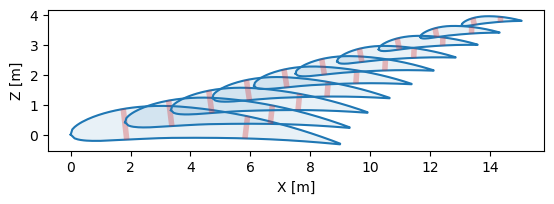

In [22]:
base.plot_side_view()

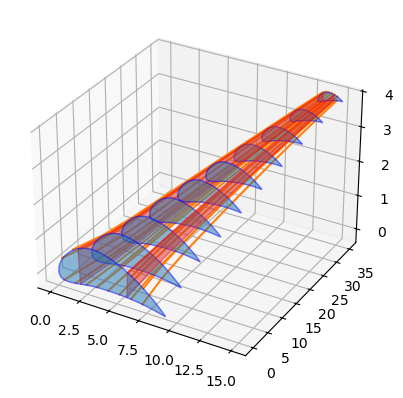

In [23]:
# %matplotlib tk
base.plot_3d_view()
# plt.savefig('Proba3d.png',dpi=500)

In [ ]:
base.save_ses()

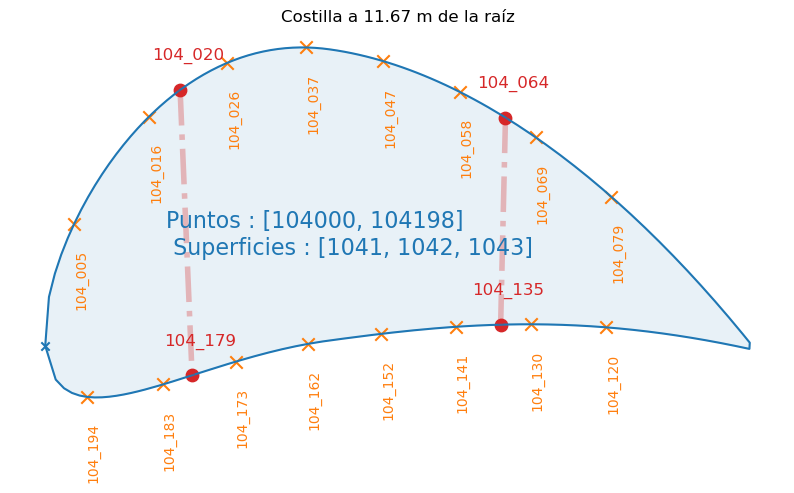

In [25]:
base.secciones[3].plot_node_names()